<a href="https://colab.research.google.com/github/AditMeh/deep-learning/blob/main/Vectorized_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np

def compute_dw(delta, a):
    """
    This function contains a vectorized implementation of computing the
    gradients of the weights given the error (delta) of layer L and the
    activations of layer L-1
    """
        batch_size, num_prev_neurons = a.shape
        _, num_curr_neurons = delta.shape

        tile_delta = np.tile(delta, (1, num_prev_neurons)).reshape((batch_size, num_prev_neurons, num_curr_neurons))
        tile_delta = np.transpose(tile_delta, (0, 2, 1))


        tile_activations = np.tile(a, (1, num_curr_neurons)).reshape(batch_size, num_curr_neurons, num_prev_neurons)


        dW =  tile_delta * tile_activations 
        dW = np.transpose(dW, (0, 2, 1))
        return dW

In [109]:
class NeuralNet:
    def __init__(self, layer_list):
        self.layers = len(layer_list)
        self.weights = []
        self.biases = []


        #randomly initialize weights and biases (scale each random value by 0.01 to prevent vanishing gradient due the saturation of sigmoid)
        for layer_index in range(1, len(layer_list)):
            self.weights.append(np.random.rand(layer_list[layer_index - 1], layer_list[layer_index])*0.01)
            self.biases.append(np.random.rand(layer_list[layer_index],)*0.01)
        
        print("Weights")
        print([element.shape for element in self.weights])

        print("\n" + "Biases")
        print([element.shape for element in self.biases])
    
    def sigmoid(self, x):
        return 1/(1 + (np.e)**(-x))
    def sigmoid_prime(self, x):
        return self.sigmoid(x)*(1 - self.sigmoid(x))
    def compute_cost(self, real, predicted, batch_size):
        return (1/batch_size) * (np.sum(1/2*(predicted - real)**2))
    def cost_derivative(self, real, predicted):
        return (predicted - real)
    
    def feedforward(self, x, output):
       self.x = x
       self.output = output

       #Activation of the input layer is equivalent to the inputs that are passed in
       current_a = self.x

       self.z = []
       self.a = [self.x]
       for w_i, b_i in zip(self.weights, self.biases):
           z_i = np.dot(current_a, w_i) + b_i

           self.z.append(z_i)
           current_a = self.sigmoid(z_i)
           self.a.append(current_a)

       return self.compute_cost(output, current_a, self.x.shape[0])
    def backward(self):
        #print([thing.shape for thing in self.a])
        w_i_grad = [np.zeros(element.shape) for element in self.weights]
        b_i_grad = [np.zeros(element.shape) for element in self.biases]

        # compute final layer error
        delta  = self.cost_derivative(self.output, (self.a)[-1]) * self.sigmoid_prime((self.z)[-1])

        w_i_grad[-1] = compute_dw(delta, self.a[-2])
        b_i_grad[-1] = delta
        # compute  
        for i in range(2, self.layers):
            z_current = self.z[-i]

            # delta non-final layer error

            delta = np.dot(delta, (self.weights[-i + 1]).T) * self.sigmoid_prime(z_current)
            #print(delta.shape)

            # Computing dC/Dw

            dW = compute_dw(delta, self.a[-i - 1])

            w_i_grad[-i] = dW
            b_i_grad[-i] = delta


        return w_i_grad, b_i_grad
    
    def update_weights_and_biases(self, w_grad, b_grad, learning_rate):        

        batch_size = w_grad[0].shape[0]
        #apply gradients to current weights
        for i in range(len(self.weights)): 
            self.weights[i] -= learning_rate*(np.sum(w_grad[i], axis = 0)/batch_size)
            self.biases[i] -= learning_rate*(np.sum(b_grad[i], axis = 0)/batch_size)

In [114]:
"""
Test run
"""

input = np.ones((10, 50))

output = np.ones((10, 1))

nn = NeuralNet([50, 20, 30, 2])

nn.feedforward(input, output)


Weights
[(50, 20), (20, 30), (30, 2)]

Biases
[(20,), (30,), (2,)]


0.23022713583367557

In [123]:
from tensorflow.keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2]) / 255

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

from sklearn.preprocessing import OneHotEncoder

def prepare_mini_batches(minibatch_size: int):
    """
    Takes in a minibatch size parameter and generates random indexes from the
    training set (X_train). Returns a list of indexes of length minibatch_size.
    """
    random_indexes = np.random.choice(X_train.shape[0], minibatch_size, replace=False)
    return random_indexes

# Creating one hot encoder
encoder = OneHotEncoder()
encoder.fit(Y_train.reshape(-1, 1))


#Initializing the neural net
nn = NeuralNet([784, 362, 100, 10])

#training loop
epochs = 300
mini_size = 32
lr = 0.01


history = []
for i in range(epochs):

    print("EPOCH: " + str(i + 1))

    #Generates a randomly chosen set of training indexes per epoch
    random_indexes = prepare_mini_batches(mini_size)
    cost_iter = nn.feedforward(X_train[random_indexes], encoder.transform(Y_train[random_indexes].reshape(-1, 1)).toarray())
    history.append(cost_iter)
    print("Cost: " + str(cost_iter))
    grads_w, grads_b = nn.backward()

    nn.update_weights_and_biases(grads_w, grads_b, learning_rate=lr)

Weights
[(784, 362), (362, 100), (100, 10)]

Biases
[(362,), (100,), (10,)]
EPOCH: 1
Cost: 1.6698500335035253
EPOCH: 2
Cost: 1.589720480992647
EPOCH: 3
Cost: 1.509052306606034
EPOCH: 4
Cost: 1.436488411567415
EPOCH: 5
Cost: 1.366004924253934
EPOCH: 6
Cost: 1.3003181411285674
EPOCH: 7
Cost: 1.2397910704392778
EPOCH: 8
Cost: 1.18219867201642
EPOCH: 9
Cost: 1.1309671768764034
EPOCH: 10
Cost: 1.0825925318740313
EPOCH: 11
Cost: 1.0384078390526619
EPOCH: 12
Cost: 0.9956272237719663
EPOCH: 13
Cost: 0.9586298997881864
EPOCH: 14
Cost: 0.9223531381256913
EPOCH: 15
Cost: 0.8946765619155291
EPOCH: 16
Cost: 0.8628365934907575
EPOCH: 17
Cost: 0.837751338694471
EPOCH: 18
Cost: 0.8105525695541862
EPOCH: 19
Cost: 0.7876482517250782
EPOCH: 20
Cost: 0.7661658611797209
EPOCH: 21
Cost: 0.7546859676831286
EPOCH: 22
Cost: 0.7298468066630636
EPOCH: 23
Cost: 0.7137086796675
EPOCH: 24
Cost: 0.7035379284274981
EPOCH: 25
Cost: 0.685262004875155
EPOCH: 26
Cost: 0.6733204355785151
EPOCH: 27
Cost: 0.6614666800265064

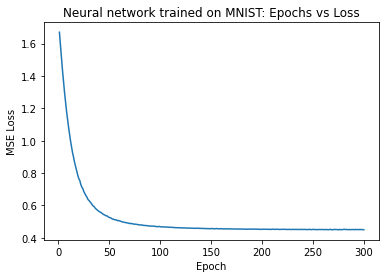

In [124]:
# Displaying the history

import matplotlib.pyplot as plt

x = [(i + 1) for i in range(len(history))]

plt.plot(x, history)
plt.title("Neural network trained on MNIST: Epochs vs Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss");
